In [2]:
import sys
import tensorflow as tf
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib


# from chat GPT 
import os
import shutil
# import pandas as pd

In [3]:
# check for GPU available or not
print(f"Python {sys.version}")
print()
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Pandas: {pd.__version__}")
print(f"Scikit-Learn: {sk.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print()
print("GPU is ", "available" if tf.config.list_physical_devices('GPU') else "not available")
print(f"CUDA: {tf.test.is_built_with_cuda()}")

Python 3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]

Tensorflow version: 2.10.1
Keras Version: 2.10.0

Pandas: 2.2.1
Scikit-Learn: 1.4.2
Numpy: 1.26.4
Matplotlib: 3.8.4

GPU is  available
CUDA: True


In [4]:
# Define the directories
source_base_dir = "D:\CXR8\images"
destination_base_dir = "E:\CVPR\Dataset\ChestX-ray"

# Load the Excel file
excel_path = "D:\CXR8\Data_Entry_2017_v2020.csv" #  .xlsx
df = pd.read_csv(excel_path) # pd.read_excel

C:\Users\Mohammad Sheakh\AppData\Local\Temp\ipykernel_5664\4105429036.py:7: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(excel_path) # pd.read_excel


In [ ]:
# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    image_index = row['Image Index']
    finding_label = row['Finding Labels']
    
    # Check if the destination directory exists
    destination_dir = os.path.join(destination_base_dir, finding_label)
    if not os.path.exists(destination_dir):
        print(f"Warning: The folder for finding label '{finding_label}' does not exist in the destination directory.")
        continue

    # Search for the image in the source directories
    image_found = False
    for i in range(1, 13):
        folder_name = f"images_{i:03d}"
        image_path = os.path.join(source_base_dir, folder_name, 'images', image_index)
        if os.path.isfile(image_path):
            # Copy the image to the destination directory
            shutil.copy(image_path, destination_dir)
            print(f"Copied {image_index} to {destination_dir}")
            image_found = True
            break

    if not image_found:
        print(f"Error: Image {image_index} not found in any source directories.")

give me a python code which take 2 path .. one is fromPath to Destination Path .. now in form path ... multiple image are there .. what you have to do.. cut the 700 images from there and paste those images into destination path ..

In [19]:
def cut_images(from_path, to_path, num_images=700):
    # Ensure the destination directory exists
    if not os.path.exists(to_path):
        os.makedirs(to_path)

    # Get a list of all files in the source directory
    files = os.listdir(from_path)

    # Iterate through the files and move the first num_images images
    moved_images = 0
    for file_name in files:
        # Check if the file is an image
        if file_name.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            # Move the image file to the destination directory
            shutil.move(os.path.join(from_path, file_name), os.path.join(to_path, file_name))
            moved_images += 1

            # Check if we've moved enough images
            if moved_images >= num_images:
                break

    print(f"{moved_images} images moved to {to_path}")

# Example usage
from_path = "E:/CVPR/Dataset/ChestX-ray/folderName"
to_path = "D:/CXR8/ChestX-ray/folderName"
cut_images(from_path, to_path, num_images=700)

700 images moved to D:/CXR8/ChestX-ray/Pneumothorax


700 images moved to D:/CXR8/ChestX-ray/Pneumothorax


In [49]:
from imgaug import augmenters as iaa
from PIL import Image

In [85]:
def augment_images(source_folder, destination_folder, target_count=700):
    # Ensure the destination directory exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get a list of all files in the source directory
    files = os.listdir(source_folder)
    current_count = len(files)

    if current_count >= target_count:
        print(f"The folder already contains {current_count} images.")
        return

    # Define augmentation sequence
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontally flip 50% of the images
        iaa.GaussianBlur(sigma=(0, 1.0)),  # blur images with a sigma of 0 to 1.0
        sometimes(iaa.Affine(
            scale={"x": (1.3, 1.2), "y": (1.3, 1.2)}, # "x": (0.8, 1.2), "y": (0.8, 1.2)
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # "x": (-0.2, 0.2), "y": (-0.2, 0.2)
            rotate=(-5, 5), # (-25, 25)
            shear=(-2, 2) # (-8, 8)
        )),
        sometimes(iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255))),
        sometimes(iaa.Dropout(p=(0, 0.1))),
        sometimes(iaa.CoarseDropout(0.1, size_percent=0.05))
    ], random_order=True)

    # Augment images until the target count is reached
    while current_count < target_count:
        # Randomly select an image file
        file_name = np.random.choice(files)
        file_path = os.path.join(source_folder, file_name)

        # Load the image and convert it to a NumPy array
        image = Image.open(file_path)
        image_np = np.array(image)

        # Augment the image
        augmented_image_np = seq.augment_image(image_np)

        # Convert the augmented image back to PIL image
        augmented_image = Image.fromarray(augmented_image_np)

        # Save the augmented image
        new_file_name = f"{current_count}_{file_name}"
        new_file_path = os.path.join(destination_folder, new_file_name)
        augmented_image.save(new_file_path)

        current_count += 1

    print(f"Total {target_count} images created and saved to {destination_folder}")

In [86]:
# Example usage
source_folder = "E:/CVPR/Dataset/ChestX-ray/Edema"
destination_folder = "D:/CXR8/ChestX-ray/Edema"
augment_images(source_folder, destination_folder, target_count=700)
# but it produce only 72 images

Total 700 images created and saved to D:/CXR8/ChestX-ray/Edema


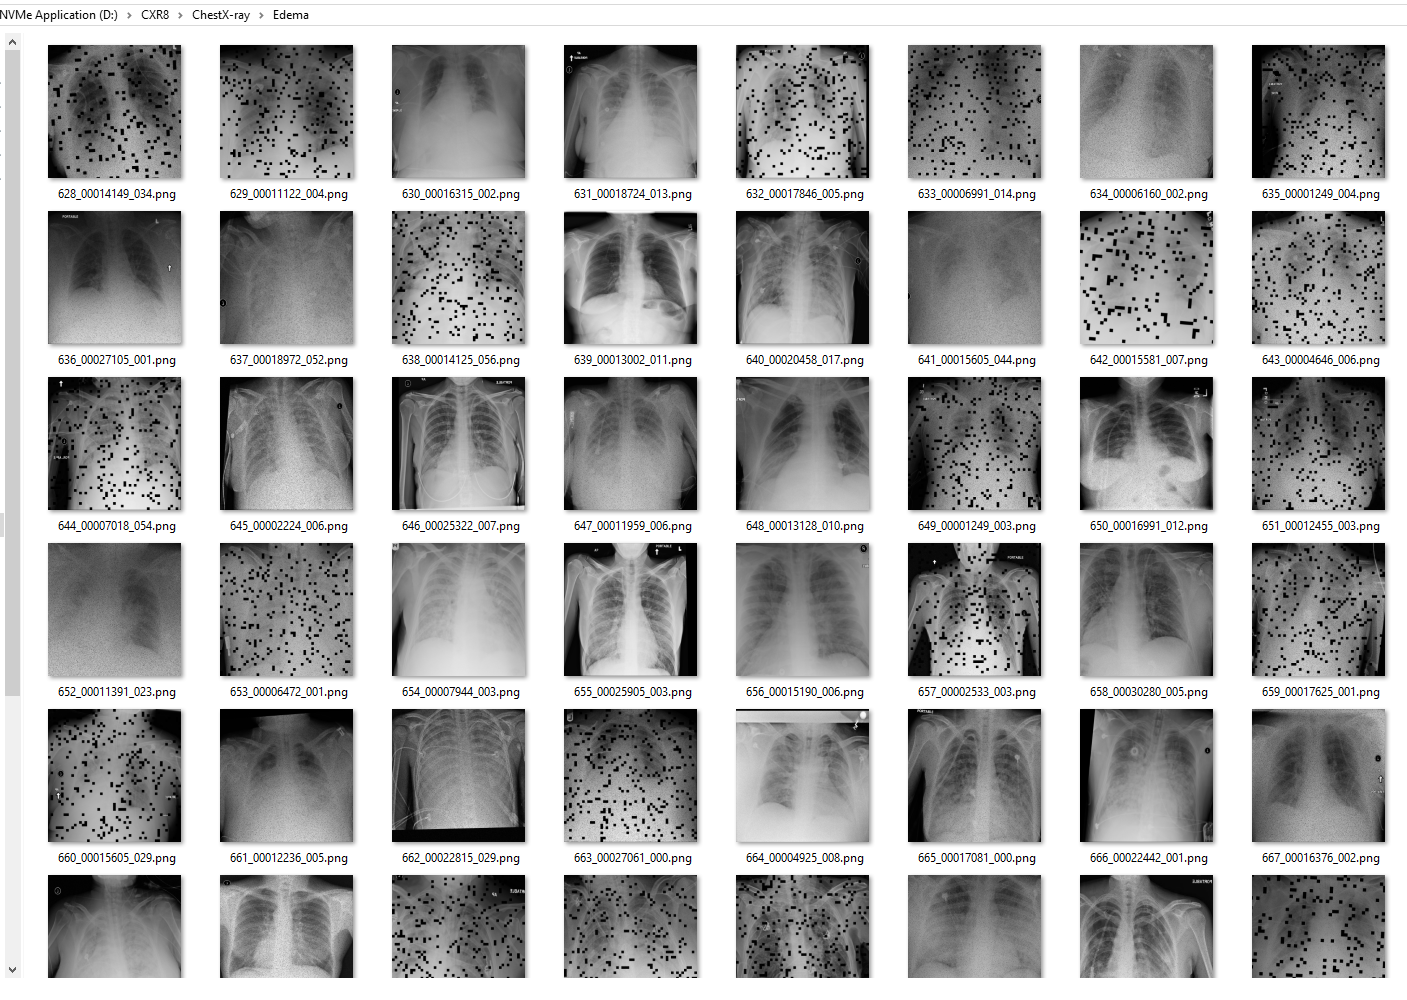